<br>
<font style="font-family:Times New Roman;font-size:60px;"><b>Machine Learning</b></font>
<br>
<font style="font-family:Times New Roman;font-size:18px;"><b>Kole Berisha</b></font>

<font style="font-family:Times New Roman;font-size:18px;">
V následujicí úloze jsem pracoval na rozpoznání kontury, obrysu, rohů a těžiště přidané kostky. Rozpoznávaní jsem řešil tak že jsem našel spodní a horní mez spektrumu barvy kostky a pak z toho udělal threshold. Jelikož je barva kostky velice podobná jiným barvám v pozadí, nepodařilo se mi všechno vyřešít hladce a dokonalé.
<br>
<br>
Na rozpoznání barvy kostky jsem našel kousek kódu a následně ho úpravil. V něm se daji úpravovat minimální a maximální hodnoty HSV (hue, saturation, value) na určeném obrázku dokud se nenáleznou požadovany hodnoty.
<br>
<br>
Převážně jsem se inspirovál <a href="https://docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html">oficiálními strankami OpenCV</a>
</font>

In [1]:
import numpy as np
import os
from os import walk
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

<font style="font-family:Times New Roman;font-size:18px;">Načtu jakoukoliv vybranou fotku s kostkou a pozadí.</font>

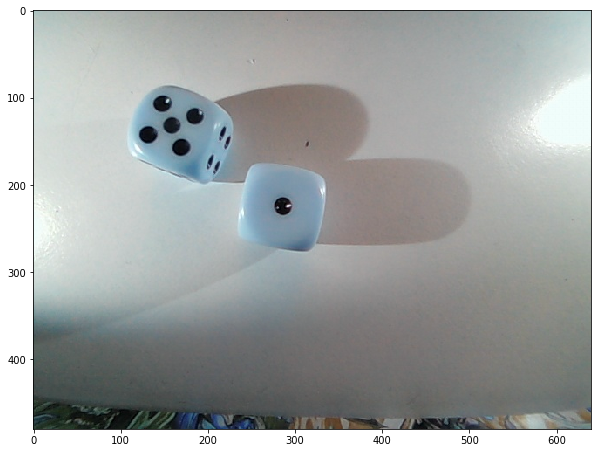

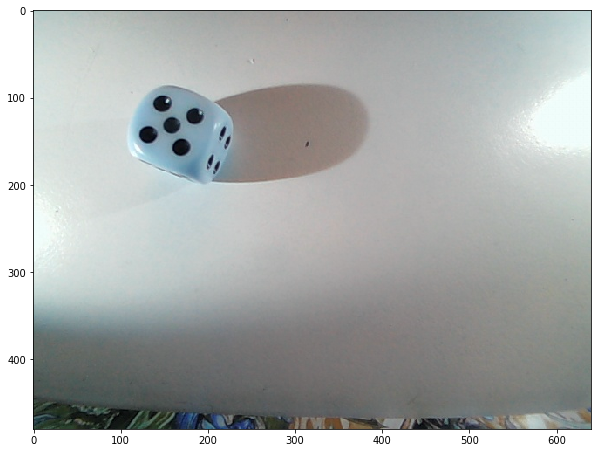

In [2]:
jedna_v1_url = r'Input\one_v1.jpg'
pozadi_url = r'Input_bg\bg.jpg'

jedna_v1 = cv2.imread(jedna_v1_url) 
pozadi = cv2.imread(pozadi_url)

plt.figure(figsize=(10,10))
plt.imshow(jedna_v1)
plt.figure(figsize=(10,10))
plt.imshow(pozadi)

<font style="font-family:Times New Roman;font-size:18px;">Překonvertování fotek do HSV</font>

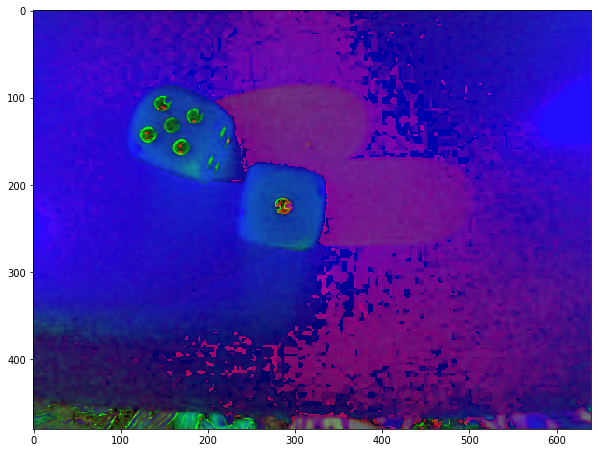

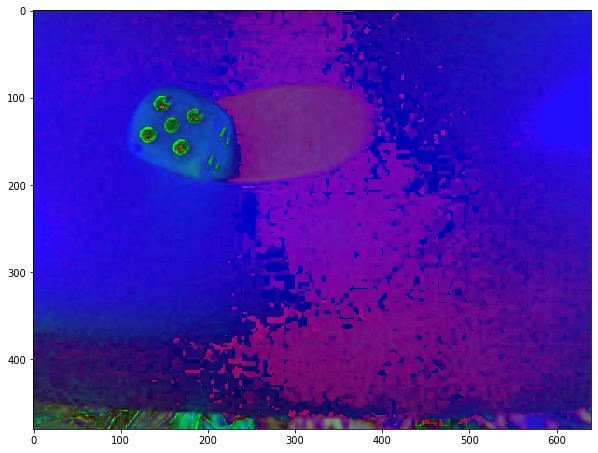

In [3]:
hsv = cv2.cvtColor(jedna_v1, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10,10))
plt.imshow(hsv)
hsv_pozadi = cv2.cvtColor(pozadi, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10,10))
plt.imshow(hsv_pozadi)

<font style="font-family:Times New Roman;font-size:18px;">
Jak jsem uvedl na začátku, následujicí spodní a horní mez jsem zjistil pomocí prográmku který přiložim taky.
</font>

In [4]:
spodni_mez = np.array([0, 42, 0])
horni_mez = np.array([30,255,255])

<font style="font-family:Times New Roman;font-size:18px;">
Aplikovat barvy na fotky
</font>

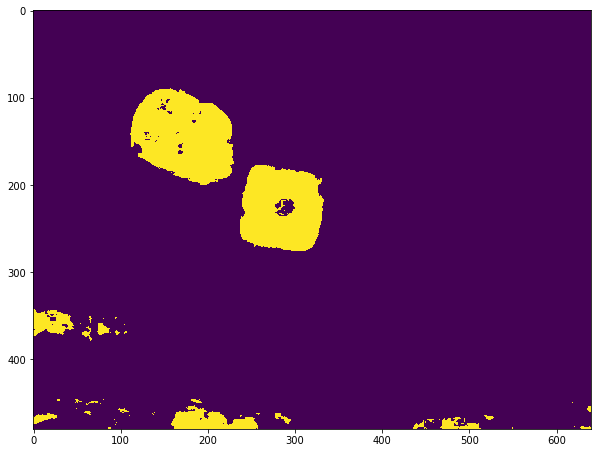

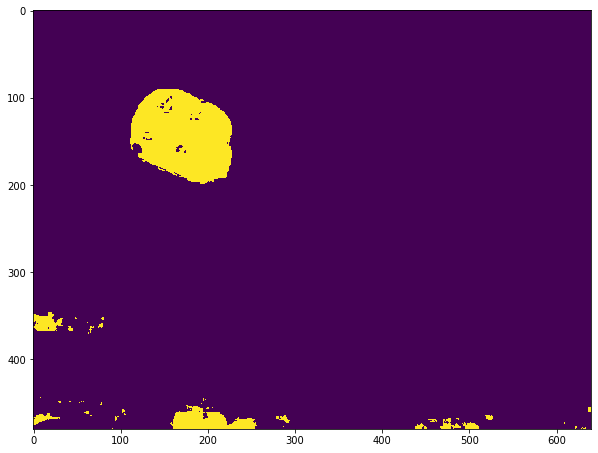

In [5]:
mask = cv2.inRange(hsv, spodni_mez, horni_mez)
plt.figure(figsize=(10,10))
plt.imshow(mask)
mask_pozadi = cv2.inRange(hsv_pozadi, spodni_mez, horni_mez)
plt.figure(figsize=(10,10))
plt.imshow(mask_pozadi)

<font style="font-family:Times New Roman;font-size:18px;">
Odečíst pozadí od chtěny fotky
</font>

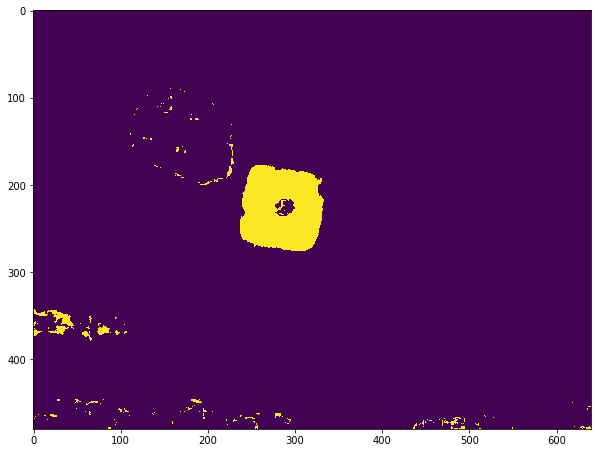

In [6]:
odectena = cv2.subtract(mask, mask_pozadi)
plt.figure(figsize=(10,10))
plt.imshow(odectena)

<font style="font-family:Times New Roman;font-size:18px;">
Threshold
</font>

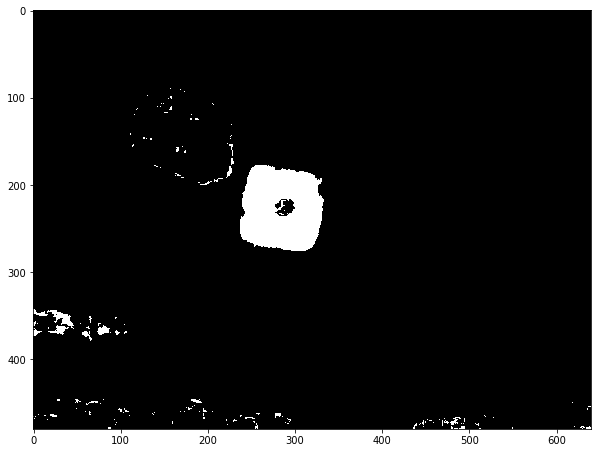

In [7]:
ret, image_threshold = cv2.threshold(odectena, 120, 255, cv2.THRESH_BINARY)  # image threshold
plt.figure(figsize=(10,10))
plt.imshow(odectena, cmap='gray', vmin=0, vmax=255)

<font style="font-family:Times New Roman;font-size:18px;">
Bohužel jsem nevěděl jak definovat aby našlo nejvetší konturu, nebo jaka by mohla byt přibližná minimální velikost největší kontury, zjistíl jsem ale že příbližná velikost kontury celé kostky je kolem 7000[-], tak jsem uvedl podmínku že by se vždy uložila kontura která je větší než 6000[-].
</font>

In [8]:
contours, hierarchy = cv2.findContours(odectena, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
target_contours = []
for contour in contours:
    contour_area = cv2.contourArea(contour)  # estimate contour area
    if contour_area > 6000:
            target_contours.append(contour)

In [9]:
len(target_contours)

1

<font style="font-family:Times New Roman;font-size:18px;">
Funkce která vraci počet kontur (vždy jedna, jen pro kontrolu), a obrázek kontury, což je kontura kostky.
</font>

In [10]:
def detect_shape(image_url, bg_url):
    img = cv2.imread(image_url)
    bg = cv2.imread(bg_url)
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2HSV)
    
    lower_color = np.array([0, 42, 0])
    upper_color = np.array([30,255,255])
    
    mask_img = cv2.inRange(hsv_img, lower_color, upper_color)
    mask_bg = cv2.inRange(hsv_bg, lower_color, upper_color)
    
    subtracted_img = cv2.subtract(mask_img, mask_bg)
    
    ret, img_threshold = cv2.threshold(subtracted_img, 120, 255, cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(subtracted_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_s = []
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area > 1500:
            contours_s.append(contour)
    return [contours_s, img_threshold]

<font style="font-family:Times New Roman;font-size:18px;">
Funkce která vrací obrazek s nakresleným obloukem a těžištěm kontury(kostky).
</font>

In [11]:
def detect_arc_center(original_image, contours):
    epsilon = 0.1*cv2.arcLength(contours,True)
    ctr_aprx = cv2.approxPolyDP(contours,epsilon,True)
    height, width, channels = original_image.shape
    im2 = Image.new('RGBA', (width, height), (0, 0, 0, 255)) 
    draw2 = ImageDraw.Draw(im2)
    for i in range(len(ctr_aprx)):
        if (i == (len(ctr_aprx)-1)):
            draw2.line((ctr_aprx[i][0][0], ctr_aprx[i][0][1], ctr_aprx[0][0][0], ctr_aprx[0][0][1]), fill=128, width=3)
        else:
            draw2.line((ctr_aprx[i][0][0], ctr_aprx[i][0][1], ctr_aprx[i+1][0][0], ctr_aprx[i+1][0][1]), fill=128, width=3)
    points = detect_mass_center(contours)
    draw2.line((points[0], points[1], (points[0]-1), (points[1]-1)), fill=128, width=4)
    return im2

<font style="font-family:Times New Roman;font-size:18px;">
Funkce která vrací body rohu kostky. Jelikož je epsilon rovno 0,1 tak se vždy vratí 4 aproximační hodnoty, hodnoty jsou body který by měli co nejlepé odhadnout obrys kostky. Tyhle 4 body uvažují za rohy kostky.
</font>

In [12]:
def detect_corners(contours):
    corners = []
    epsilon = 0.1*cv2.arcLength(contours,True)
    ctr_aprx = cv2.approxPolyDP(contours,epsilon,True)
    for i in range(len(ctr_aprx)):
        corners.append(ctr_aprx[i][0])
    return corners

<font style="font-family:Times New Roman;font-size:18px;">
Funkce která vrací souřadnice x a y těžiště kontury.
</font>

In [13]:
def detect_mass_center(contours):
    center_points = []
    M = cv2.moments(contours)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    center_points.append(cX)
    center_points.append(cY)
    return center_points

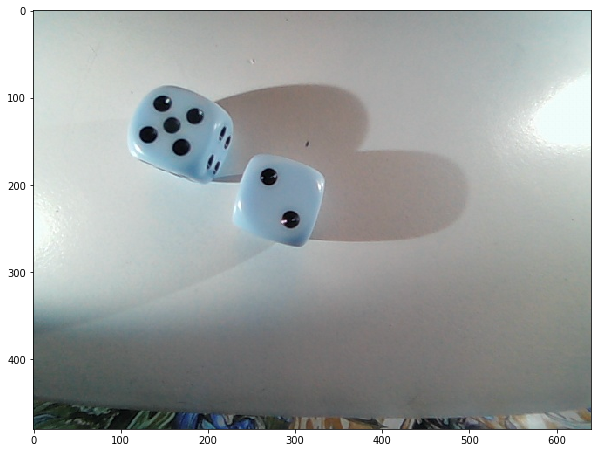

In [14]:
two_v1 = cv2.imread(r'Input\two_v1.jpg') 

plt.figure(figsize=(10,10))
plt.imshow(two_v1)

two_v1_contours, two_v1_threshold = detect_shape(r'Input\two_v1.jpg', r'Input_bg\bg.jpg')
two_v1_arc = detect_arc_center(two_v1, two_v1_contours[0])
two_v1_corners = detect_corners(two_v1_contours[0])
two_v1_center = detect_mass_center(two_v1_contours[0])

Počet nalezených kontur: 1

Rohy kontury:
[253 170]
[232 245]
[309 268]
[329 190]

Těžiště kontury: [281, 219]

Nakreslený oblouk a těžiště kontury:


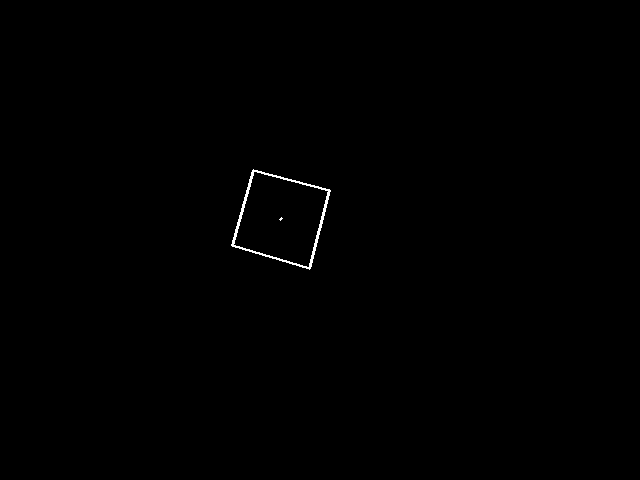

In [15]:
print("Počet nalezených kontur: " + str(len(two_v1_contours)))
print("\nRohy kontury:")
for i in two_v1_corners:
      print(i)

print("\nTěžiště kontury: " + str(two_v1_center))

print("\nNakreslený oblouk a těžiště kontury:")
detect_arc_center(two_v1, two_v1_contours[0])

<font style="font-family:Times New Roman;font-size:18px;">
Kontrola jestli se v každým obrázku rozpozná kostka.
</font>

In [16]:
preklad = {
    "one" : "1",
    "two" : "2",
    "three" : "3",
    "four" : "4",
    "five" : "5",
    "six" : "6",
}

verze = {
    "v1" : "verze 1",
    "v2" : "verze 2",
    "v3" : "verze 3"
}

pozadi_cesta = 'Input_bg\\bg.jpg'
cesta_zz = r'Input'
soubory = next(os.walk(cesta_zz))[2]

poradi = 0;
for i in soubory:
    poradi = poradi + 1
    c = cesta_zz + '\\' + i
    a, b = detect_shape(c, pozadi_cesta)
    
    c_1 = c.split("\\")
    c_2 = c_1[1].split(".")
    rozklad = c_2[0].split("_")
    
    if len(a) == 1:
        print(str(poradi) + ". Kostka s počtem " + preklad[rozklad[0]] + " " + verze[rozklad[1]] + ": True")
    else:
        print(str(poradi) + ". Kostka s počtem " + preklad[rozklad[0]] + " " + verze[rozklad[1]] + ": False")

1. Kostka s počtem 5 verze 1: True
2. Kostka s počtem 5 verze 2: True
3. Kostka s počtem 5 verze 3: True
4. Kostka s počtem 4 verze 1: True
5. Kostka s počtem 4 verze 2: True
6. Kostka s počtem 4 verze 3: True
7. Kostka s počtem 1 verze 1: True
8. Kostka s počtem 1 verze 2: True
9. Kostka s počtem 1 verze 3: True
10. Kostka s počtem 6 verze 1: True
11. Kostka s počtem 6 verze 2: True
12. Kostka s počtem 6 verze 3: True
13. Kostka s počtem 3 verze 1: True
14. Kostka s počtem 3 verze 2: True
15. Kostka s počtem 3 verze 3: True
16. Kostka s počtem 2 verze 1: True
17. Kostka s počtem 2 verze 2: True
18. Kostka s počtem 2 verze 3: True
